In [1]:
import os
import re

from dotenv import load_dotenv, find_dotenv
from langchain_openai import ChatOpenAI

from agent.utils.loader import load_processed_data

_ = load_dotenv(find_dotenv())
# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_PROJECT"] = "self-correct"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"

In [19]:
meta_info = {
	"dataset_name": 'tabmwp1k',
	"mode": "self-improve",
	"base_mode": "pot",
	"model": "gpt-4o-mini-2024-07-18",
	"num_samples": -1,
	"top_p": 0.95,
	"temperature": 0,
	"seed": 42,
	"batch_size": 100
}
assert meta_info["mode"] == "self-improve"
assert meta_info["dataset_name"] in ["gsm8k", "math", "gsmhard", "tabmwp", "svamp", "tabmwp1k"], "Invalid dataset name"

processed_data_path = f"../../../data/processed_data/{meta_info['dataset_name']}.jsonl"

dataset = load_processed_data(dataset_name=meta_info["dataset_name"], file_path=processed_data_path)
if meta_info["dataset_name"] == "tabmwp":
	dataset = dataset.select_columns(["question", "answer", "ques_type", "ans_type", ])
elif meta_info["dataset_name"] in ["tabmwp1k", "svamp"]:
	dataset = dataset.map(lambda x: {"question": f"{x['context']}\n\n{x['question']}"}).remove_columns(["context"])
model = ChatOpenAI(
	model_name=meta_info["model"],
	top_p=meta_info["top_p"],
	temperature=meta_info["temperature"],
	seed=meta_info["seed"],
	openai_api_base="https://api.chsdw.top/v1"
)

if meta_info["num_samples"] > 0:
	dataset = dataset.select(range(meta_info["num_samples"]))
print(dataset[2])

{'question': 'Read the following table regarding "Average food preparation time" and then answer a question.\n\nDay | Food preparation time (minutes)\nMonday | 25\nTuesday | 27\nWednesday | 18\nThursday | 21\nFriday | 27\n\nA restaurant\'s average food preparation time was tracked from day to day as part of an efficiency improvement program. According to the table, what was the rate of change between Wednesday and Thursday?', 'answer': '3', 'ques_type': 'free_text', 'choices': None}


In [12]:

from langchain_core.messages import BaseMessage
from typing import Sequence
from typing_extensions import TypedDict


class State(TypedDict):
	question: str
	guidance: str
	fusion: str
	prediction: str

In [13]:
from langchain_core.messages import AIMessage
from langchain_core.prompts import ChatPromptTemplate

guidance_prompt = ChatPromptTemplate.from_messages(
	[
		(
			"system",
			"You are a question planner and error prone points identifier. Given a question or problem, your job is to come up with a step by step plan, and you should also identify the most error-prone points for each step, following them closely behind each step. Do not add any superfluous steps. Make sure that each step has all the information needed - do not skip steps. You should focus on the logic of how to solve the problem, rather than actually solving it."
		),
		(
			"user",
			"Question: {question}"
		)
	])
guidance_generator = guidance_prompt | model


async def guidance_node(state: State) -> State:
	assert state["question"] is not None, "Question is required"
	question:str = state["question"]
	guidance:AIMessage = await guidance_generator.ainvoke(input={"question": question})
	state["guidance"] = guidance.content
	return state

In [14]:
from langchain_core.messages import HumanMessage

fusion_prompt = ChatPromptTemplate.from_messages(
	[
		(
			"system",
			"You are a fusion agent. Given a question or problem and based on the guidance, your job is to answer the question. "
			"Your response should contains two part, the first part is the fusion of the Revising Process and the second part is the final answer. In the fusion part, you should extract the information from the tool result and also indicate how you obtained the information.(which tool, which part of the result) In the final answer, "
			"do not include any explanations, context, or additional information. Just focus on delivering the exact answer as concisely as possible!!! "
			"There is no need to answer the question in the form of a complete sentence, just provide the answer in the form of a noun, time, entity, single number, yes or no, etc."
		),
		(
			"placeholder",
			"{messages}"
		),
		(
			"user",
			"Now based on the previous information, please fuse the tool results and revise your answer. Use the XML tag <fusion></fusion> to indicate the fusion part and <answer></answer> to indicate the final answer part."
		)
	])
fusion_generator = fusion_prompt | model

async def fusion_node(state: State) -> State:
	assert state["question"] is not None, "Question is required"
	assert state["guidance"] is not None, "Guidance is required"
	guidance_messages:Sequence[BaseMessage] = [HumanMessage(content=state["question"]), AIMessage(content=state["guidance"])]
	response:AIMessage = await fusion_generator.ainvoke(input={"messages": guidance_messages})
	fusion_matches = re.findall(r"<fusion>(.*?)</fusion>", response.content, re.DOTALL)
	answer_matches = re.findall(r"<answer>(.*?)</answer>", response.content, re.DOTALL)
	if fusion_matches:
		state["fusion"] = fusion_matches[0]
	else:
		state["fusion"] = response.content
	if answer_matches:
		state["prediction"] = answer_matches[0]
	else:
		state["prediction"] = "None"

	return state



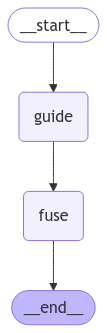

In [15]:
from langgraph.graph import StateGraph

workflow = StateGraph(State)
workflow.add_node("guide", guidance_node)
workflow.add_node("fuse", fusion_node)

workflow.set_entry_point("guide")
workflow.add_edge("guide", "fuse")
workflow.add_edge("fuse", "__end__")

app = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [16]:
inputs = {**dataset[3], "messages": []}
async for event in app.astream(inputs):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'question': 'James decides to run 3 sprints 3 times a week.  He runs 60 meters each sprint.  How many total meters does he run a week?', 'guidance': 'Step 1: Determine the total distance James runs in one sprint.  \n- **Error-prone point**: Ensure that the distance per sprint is correctly noted as 60 meters.\n\nStep 2: Calculate the total distance James runs in one session of 3 sprints.  \n- Formula: Total distance in one session = Number of sprints x Distance per sprint  \n- **Error-prone point**: Ensure the multiplication is done correctly (3 sprints * 60 meters).\n\nStep 3: Calculate the total number of sessions James runs in a week.  \n- He runs 3 times a week.  \n- **Error-prone point**: Verify that the number of sessions is correctly interpreted as 3.\n\nStep 4: Calculate the total distance James runs in a week.  \n- Formula: Total distance in a week = Total distance in one session x Number of sessions per week  \n- **Error-prone point**: Ensure that you correctly multiply the t

In [25]:
from tqdm.asyncio import tqdm_asyncio
import os
import json
import logging
import nest_asyncio

# 配置logger
logging.basicConfig(
    level=logging.ERROR,  # 设置日志级别
    format='%(asctime)s - %(levelname)s - %(message)s',  # 设置日志格式
    handlers=[
        logging.FileHandler("inference.log"),  # 将日志输出到文件
        logging.StreamHandler()  # 也输出到控制台
    ]
)

logger = logging.getLogger("InferenceLogger")

nest_asyncio.apply()
results = []
batch_size = 100
save_results_path = f"../../../output/ablation/{meta_info['model']}/{meta_info['dataset_name']}/{meta_info['mode']}/without_critique_{meta_info['base_mode']}_num_samples_{meta_info['num_samples']}_top_p_{meta_info['top_p']}_temperature_{meta_info['temperature']}_seed_{meta_info['seed']}.jsonl"

async def process(item):
    try:
        state = await app.ainvoke({**item})
        logger.info(f"Processed item: {item}")
        return {**item, **state}
    except Exception as e:
        logger.error(f"Error processing item: {item}. Error: {e}")
        return {**item, "prediction": "None"}

async def self_improve_inference() -> None:
    error_indices = []  # 用于记录包含 "ERROR" 的条目索引

    # 读取已有结果或初始化文件
    if os.path.exists(save_results_path):
        logger.info(f"Loading existing results from {save_results_path}")
        with open(save_results_path, 'r') as file:
            for idx, line in enumerate(file):
                result = json.loads(line)
                results.append(result)
                # 检查是否存在 "prediction: ERROR"
                if "None" == result.get("prediction"):
                    error_indices.append(idx)
    else:
        folder_path = os.path.dirname(save_results_path)
        os.makedirs(folder_path, exist_ok=True)
        logger.info(f"Created directory for results: {folder_path}")

    # 重新推理错误的数据
    if error_indices:
        logger.warning(f"Found {len(error_indices)} ERROR entries. Retrying inference...")
        error_data = [dataset[idx] for idx in error_indices]
        new_results = await tqdm_asyncio.gather(*(process(item) for item in error_data))
        # 更新原始结果
        for i, new_result in zip(error_indices, new_results):
            results[i] = new_result


    for idx in range(len(results), dataset.num_rows, batch_size):
        batch = dataset.select(range(idx, min(idx + batch_size, dataset.num_rows)))
        batch_results = await tqdm_asyncio.gather(*(process(item) for item in batch))
        results.extend(batch_results)

        logger.info(f"Processed batch starting at index {idx}")

        # 保存结果
        with open(save_results_path, 'qa') as file:
            for result in results:
                file.write(json.dumps(result) + "\n")
        logger.info(f"Saved results to {save_results_path}")

In [26]:
await self_improve_inference()
# 保存结果

100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


In [ ]:
with open(save_results_path, 'qa') as file:
	for result in results:
		file.write(json.dumps(result) + "\n")
logger.info(f"Saved results to {save_results_path}")